# Anomaly Detection in Blockchain System with TODS

## Introduction Summary

### What is TODS?

TODS, developed by DATA Lab @ Texas A&M University, is a full-stack automated machine learning system for outlier detection on multivariate time-series data. TODS provides exhaustive modules for building machine learning-based outlier detection systems, including: data processing, time series processing, feature analysis (extraction), detection algorithms, and reinforcement module.

### What is the Blockchain System?

"A blockchain is, in the simplest of terms, a time-stamped series of immutable records of data that is managed by a cluster of computers not owned by any single entity. Each of these blocks of data (i.e. block) is secured and bound to each other using cryptographic principles (i.e. chain)." 

More information about blockchain can be found at https://blockgeeks.com/guides/what-is-blockchain-technology/

### How does TODS detect anomalies from Blockchain System?

TODS system can perform three common outlier detection scenarios on time-series data: point-wise detection (time points as outliers), pattern-wise detection (subsequences as outliers), and system-wise detection (sets of time series as outliers).

In this notebook, we use Google BigQuery Bitcoin Blockchain Dataset, which contains information about dates, transactions, blocks and prices of Bitcoin. According to Google, this dataset updates every 10 minutes in the following link:
https://bigquery.cloud.google.com/dataset/bigquery-public-data:bitcoin_blockchain

With TODS, we first collect and process the data to put in a dataframe. Next, we use two primitives from TODS to fit and predict on all dimensions of the data, to get the prediction labels and scores. Last, we use the prediction information from TODS primitives to plot and visualize the outliers within the data.

The searcher of TODS will take the dataset and automatically build a pipeline to find the best possible model with its scores. 

## Packages and Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install google-cloud-bigquery


Note: you may need to restart the kernel to use updated packages.


In [3]:
from google.cloud import bigquery
from scipy.stats.mstats import zscore
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tods.sk_interface.detection_algorithm.Telemanom_skinterface import TelemanomSKI
from tods.sk_interface.detection_algorithm.DeepLog_skinterface import DeepLogSKI
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib as mpl
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import datetime as dt
from datetime import datetime,tzinfo
import scipy, json, csv, time, pytz
from pytz import timezone
import numpy as np
import pandas as pd
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
# os.listdir('./')

d3m.primitives.tods.detection_algorithm.LSTMODetector: Primitive is not providing a description through its docstring.


## Processing Data

In [4]:
#Connecting to Google datastore (use path to ur private key)
os.environ['GOOGLE_APPLICATION_CREDENTIALS']="blockchain-316820-a21123305db7.json"
client = bigquery.Client()

In [5]:
# The query to get date, number of transactions from Google BigQuery bitcoin blockchain dataset 
# Select records from the last three years and group them with respect to date
query_1 = """
SELECT 
   DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
   COUNT(transactions) AS Transactions
FROM `bigquery-public-data.bitcoin_blockchain.blocks`
GROUP BY date
HAVING date >= '2009-01-09' AND date <= '2020-06-12'
ORDER BY date
"""
query_job_1 = client.query(query_1)
# Waits for the query to finish
iterator_1 = query_job_1.result(timeout=30)
rows_1 = list(iterator_1)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

In [6]:
# The query to get sum of all satoshis spent each day and number of blocks
query_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (
  SELECT
    DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
    output.output_satoshis AS output_price,
    block_id AS block
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2009-01-09' AND o.date <= '2020-06-12'
ORDER BY o.date, blocks
"""
query_job_2 = client.query(query_2)
# Waits for the query to finish
iterator_2 = query_job_2.result(timeout=30)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))

df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))

In [7]:
df_1.head()

,Date,Transactions
0,2009-01-09,14
1,2009-01-10,61
2,2009-01-11,93
3,2009-01-12,94
4,2009-01-13,123


In [8]:
df_2.head()

,Date,Blocks,Output_Satoshis
0,2009-01-09,14,700.0
1,2009-01-10,61,3050.0
2,2009-01-11,93,4650.0
3,2009-01-12,106,4879.0
4,2009-01-13,123,6150.0


In [9]:
# merge the two dataframes
result = pd.merge(df_1,
                 df_2[['Date', 'Blocks', 'Output_Satoshis']],
                 on='Date')
result.head()

,Date,Transactions,Blocks,Output_Satoshis
0,2009-01-09,14,14,700.0
1,2009-01-10,61,61,3050.0
2,2009-01-11,93,93,4650.0
3,2009-01-12,94,106,4879.0
4,2009-01-13,123,123,6150.0


In [10]:
result.describe()

,Transactions,Blocks,Output_Satoshis
count,3532.000000,3.532000e+03,3.532000e+03
mean,153.053228,2.623631e+05,1.358730e+06
std,37.978411,2.799358e+05,2.193636e+06
min,2.000000,4.000000e+00,2.000000e+02
25%,138.000000,1.161975e+04,3.047457e+05
50%,153.000000,1.586145e+05,9.436964e+05
75%,169.000000,5.145980e+05,1.835461e+06
max,692.000000,2.035035e+06,6.735430e+07


<AxesSubplot:>

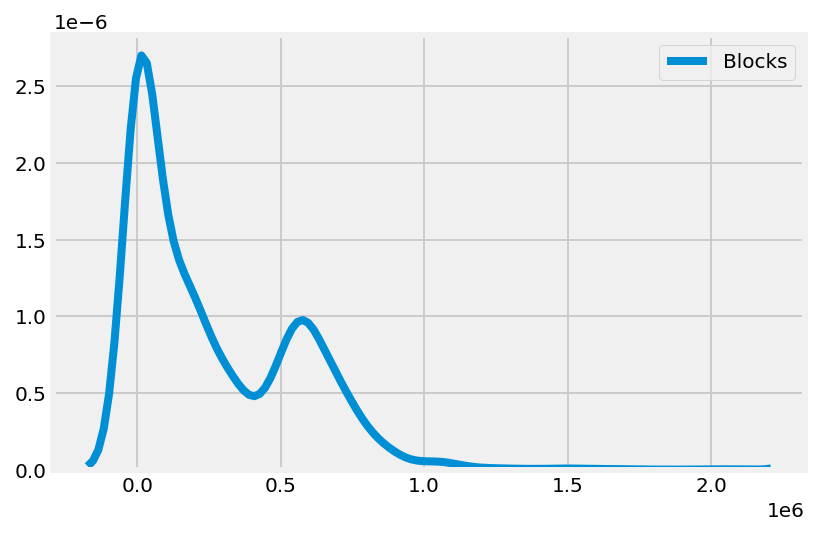

In [11]:
sns.kdeplot(result['Blocks'])

<AxesSubplot:>

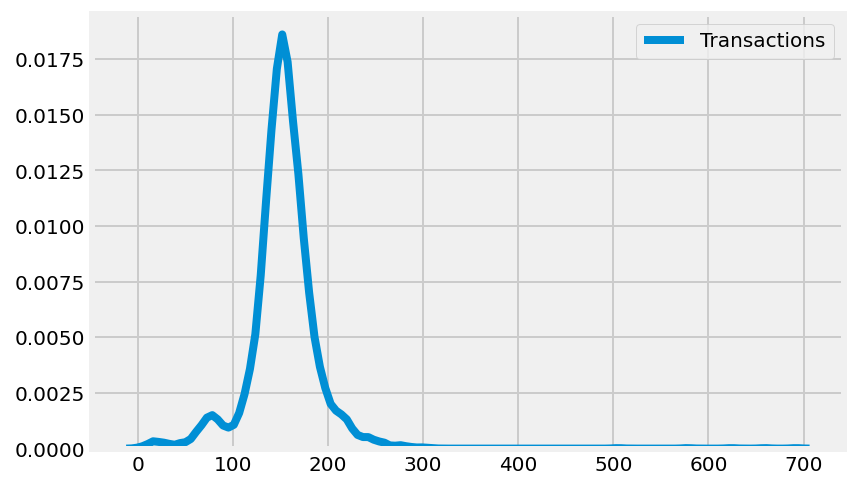

In [12]:
sns.kdeplot(result['Transactions'])

<AxesSubplot:>

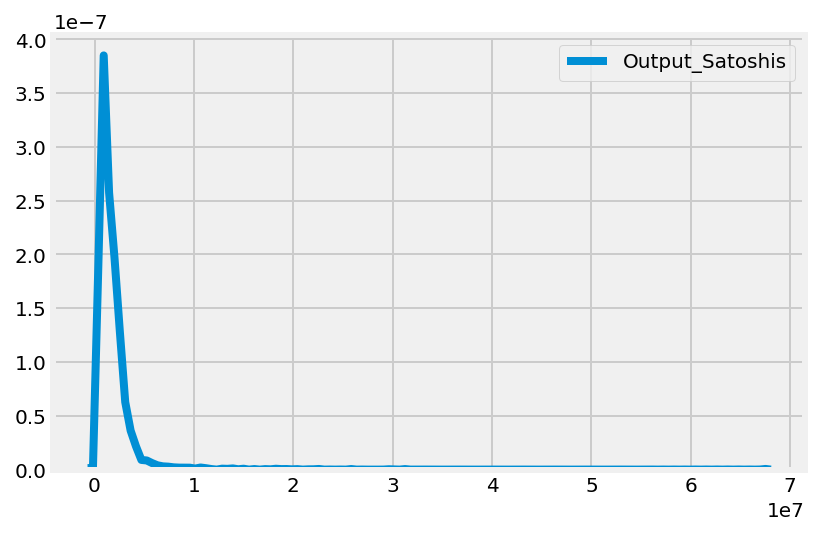

In [13]:
sns.kdeplot(result['Output_Satoshis'])

Text(0.5, 1.0, 'Transactions per day')

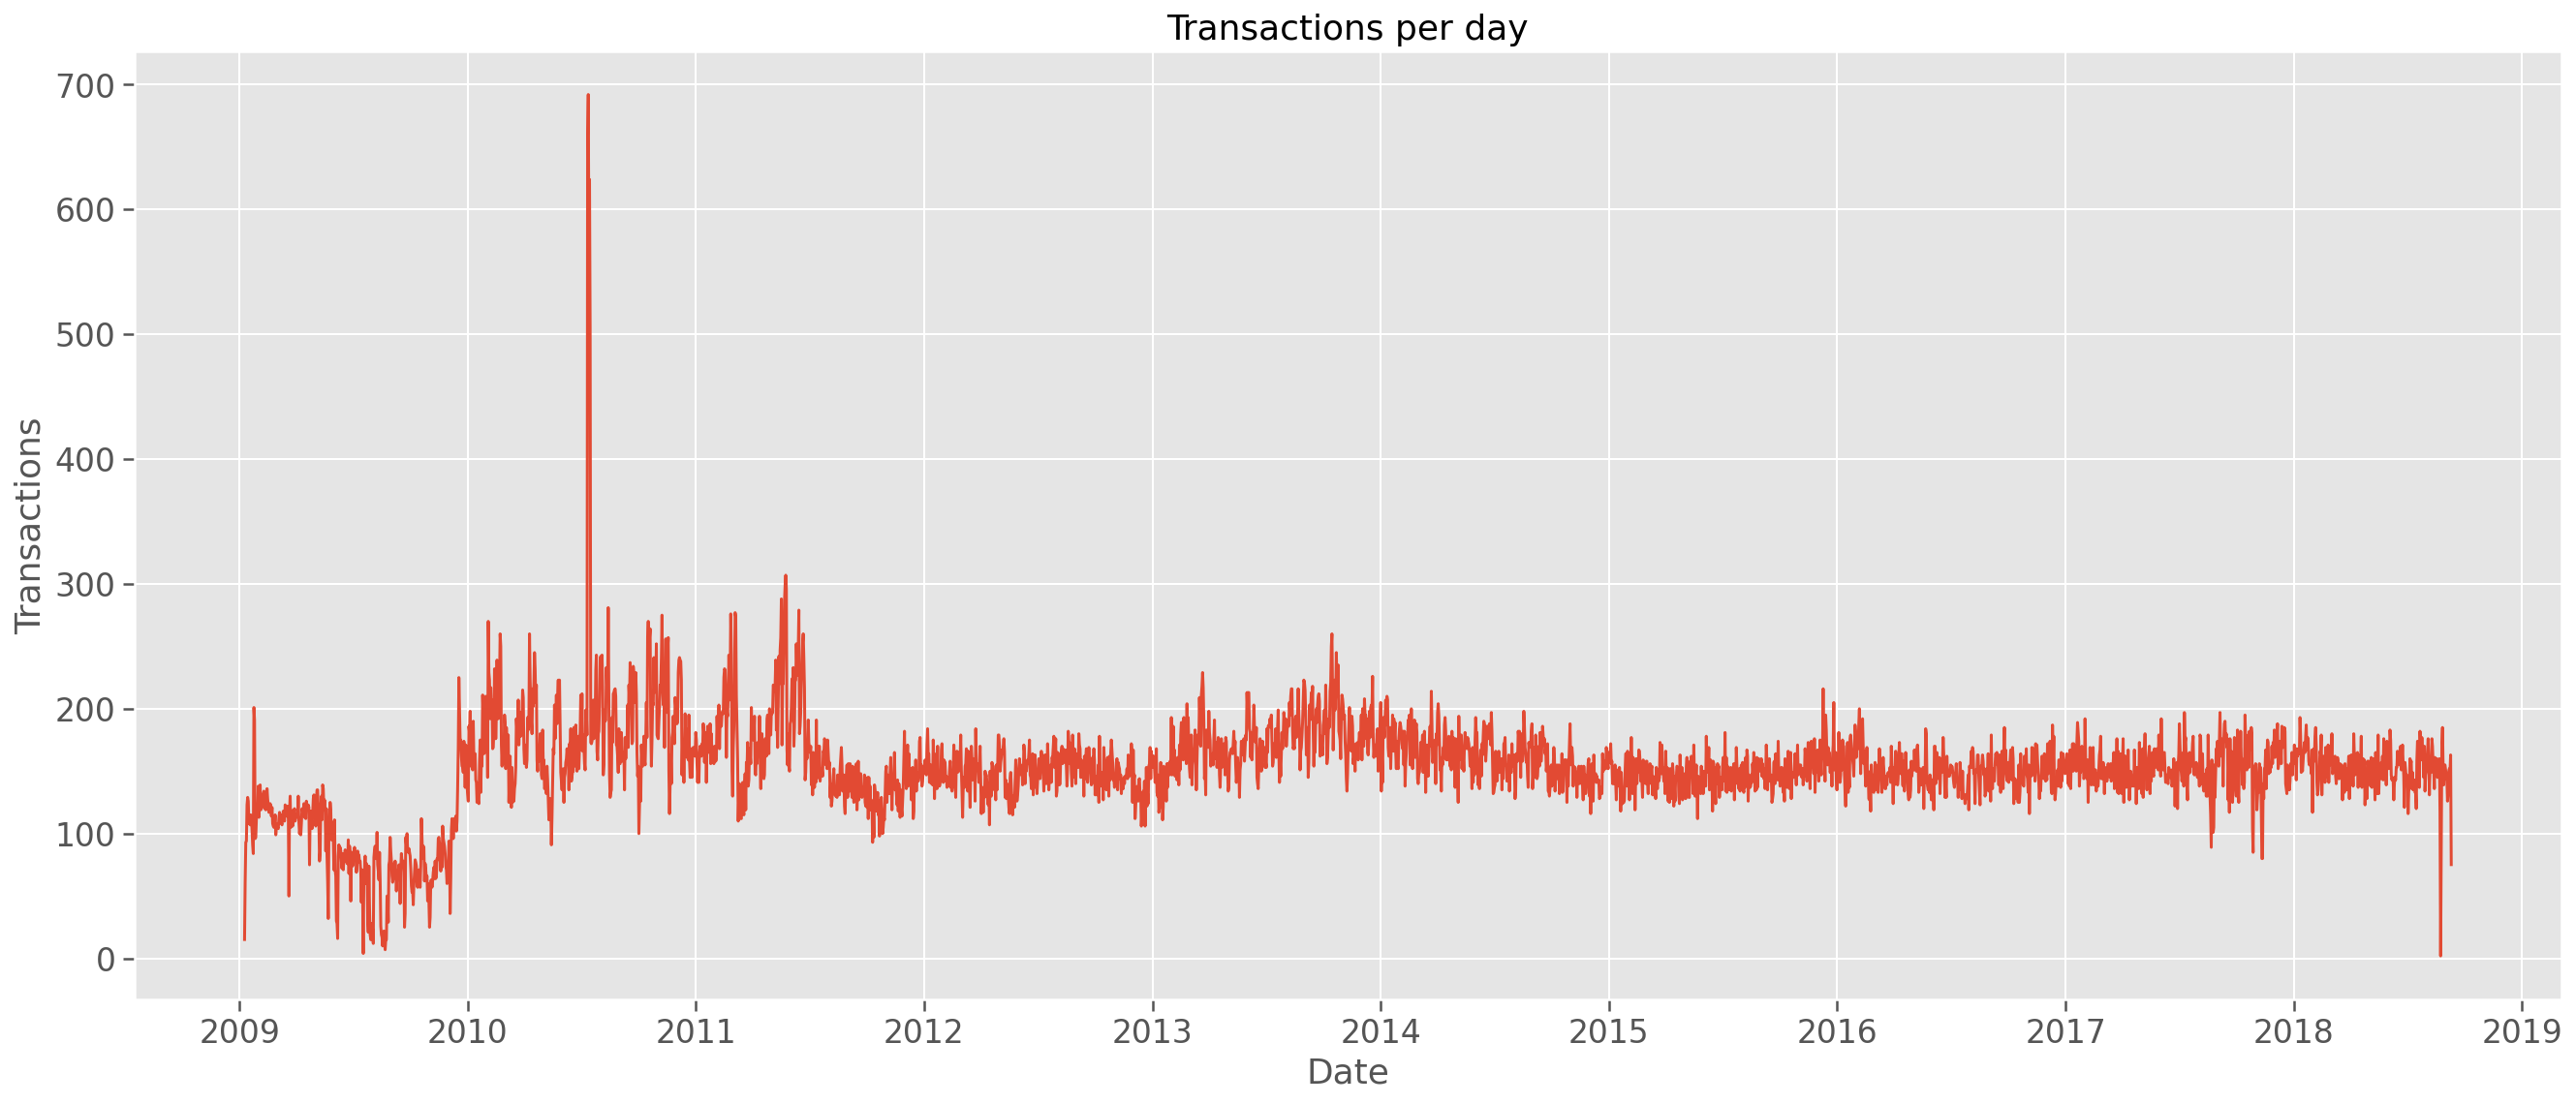

In [14]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Transactions', data=result, palette='Blues_d')
plt.title('Transactions per day')

Text(0.5, 1.0, 'Blocks per day')

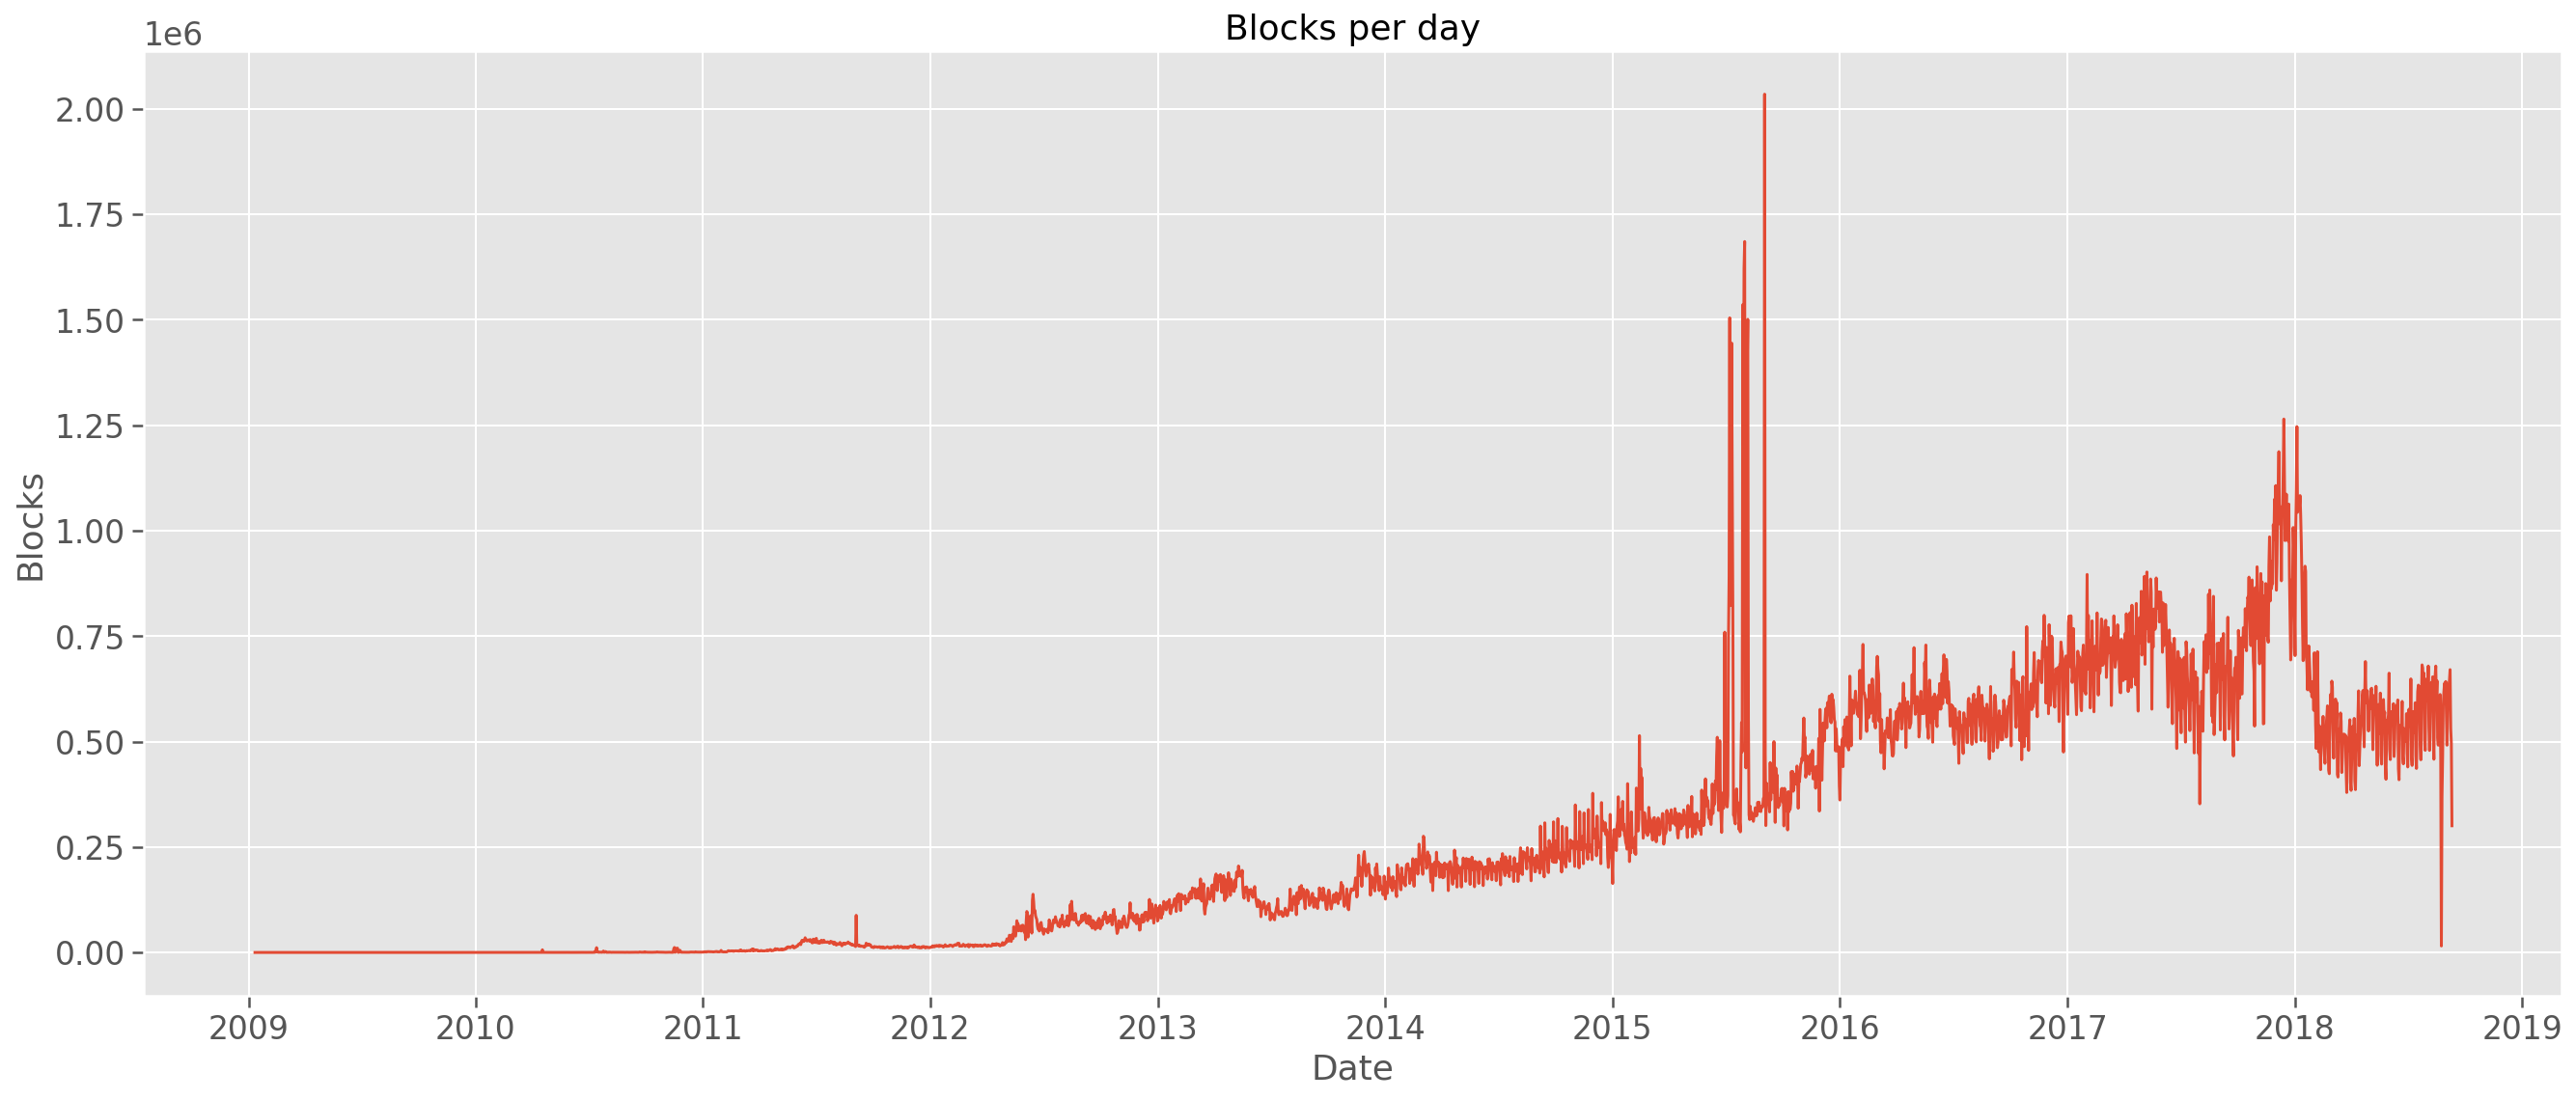

In [15]:
%matplotlib inline
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})

g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Blocks', data=result, palette='Blues_d')
plt.title('Blocks per day')

Text(0.5, 1.0, 'Sum of all satoshis spent each day')

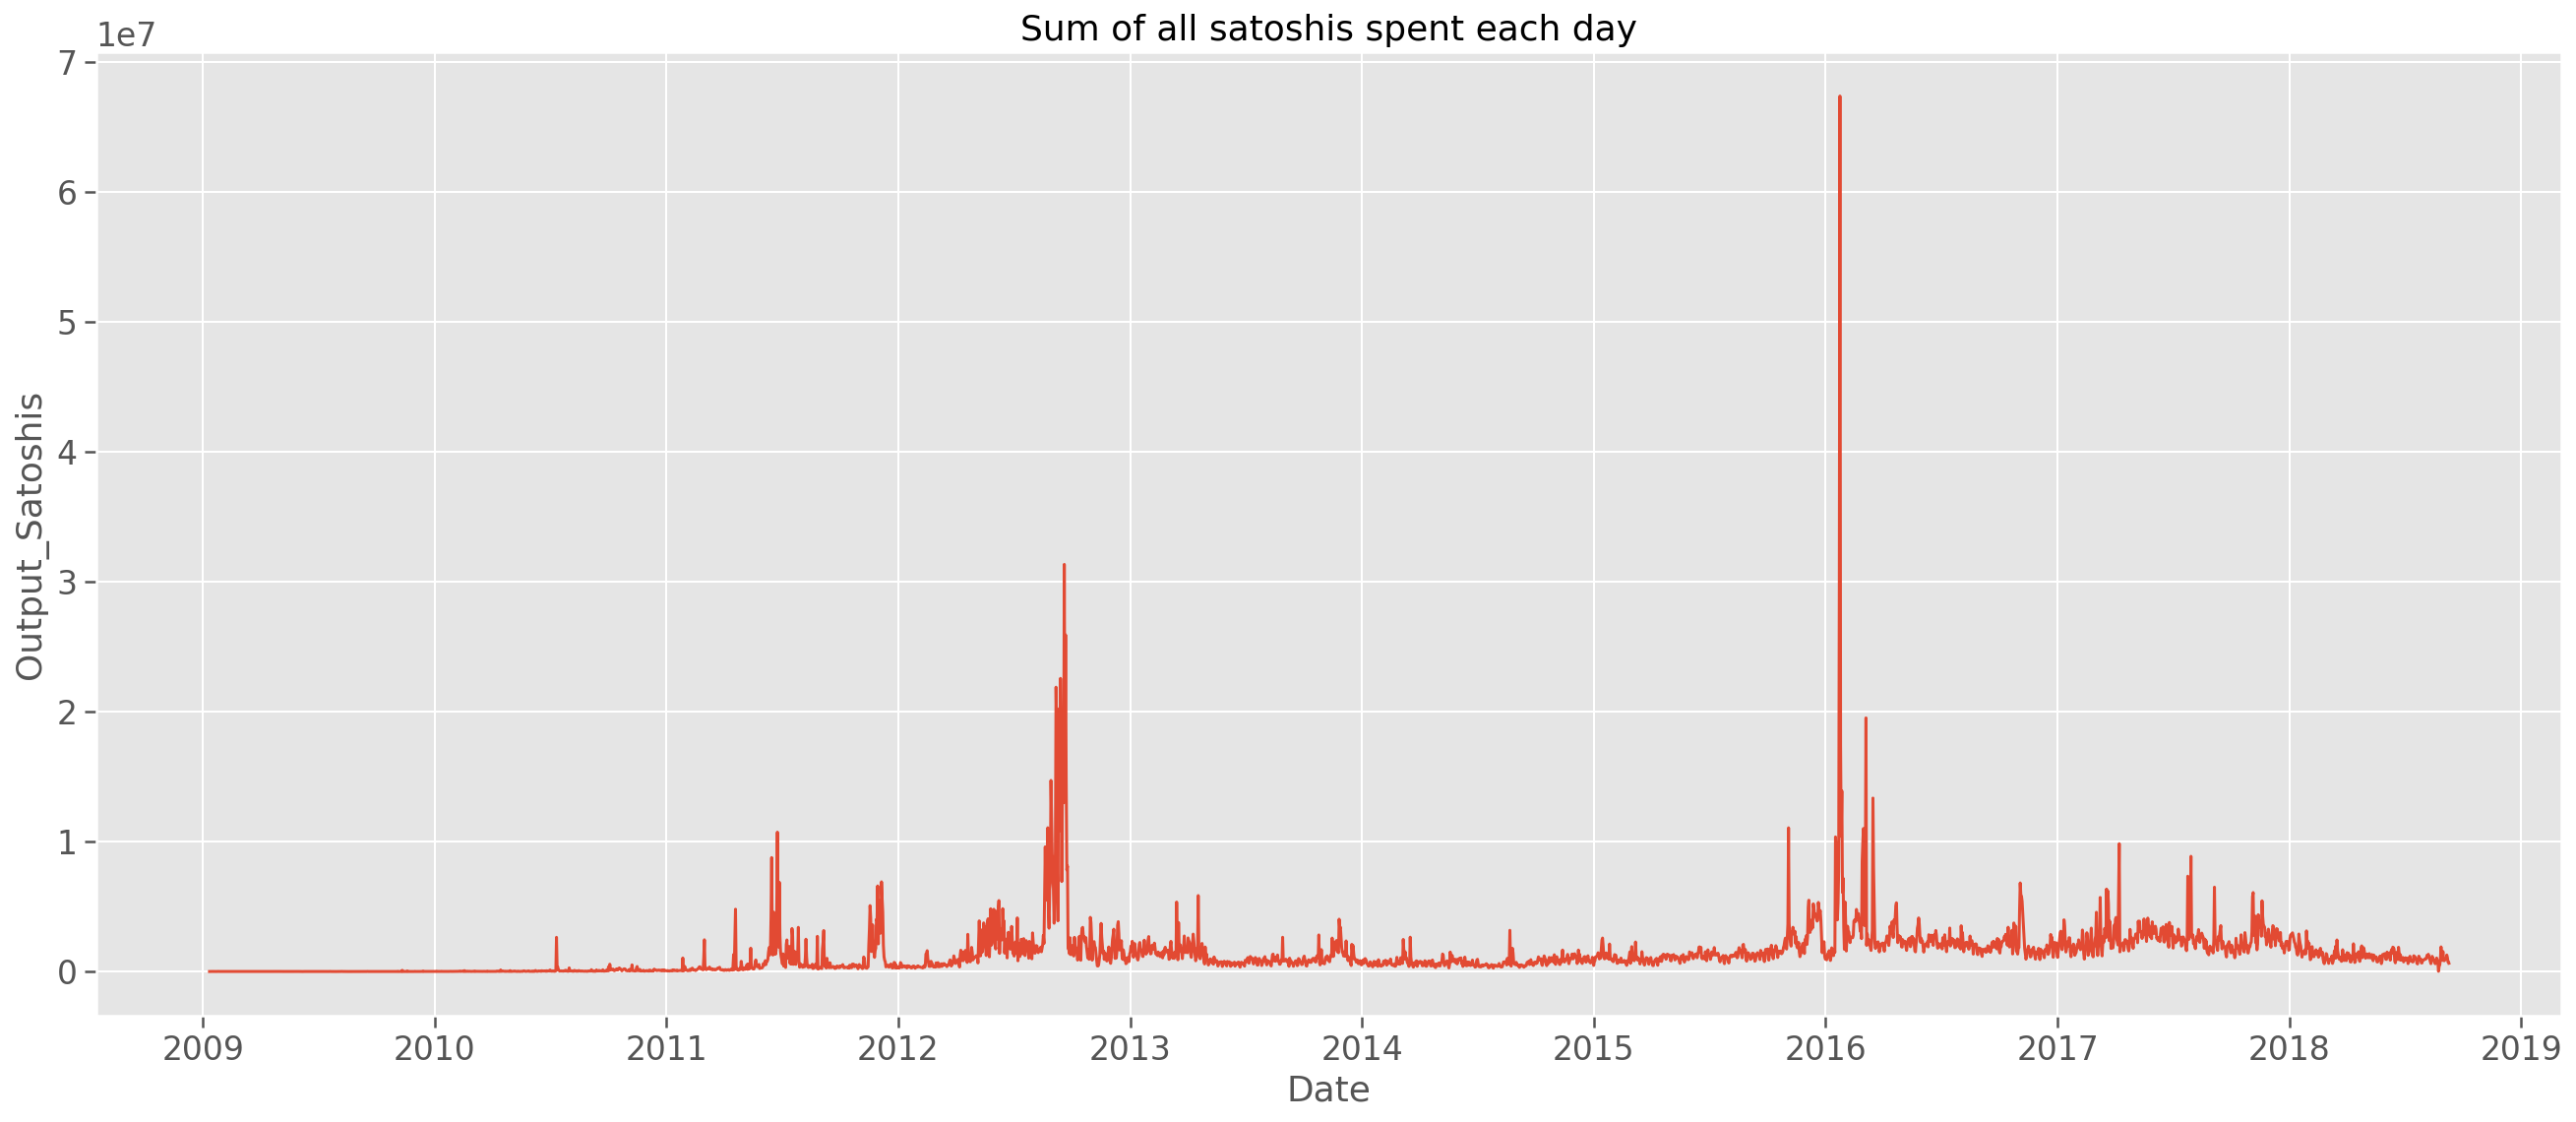

In [16]:
g = plt.subplots(figsize=(20,9))
g = sns.lineplot(x='Date', y='Output_Satoshis', data=result, palette='BuGn_r')
plt.title('Sum of all satoshis spent each day')

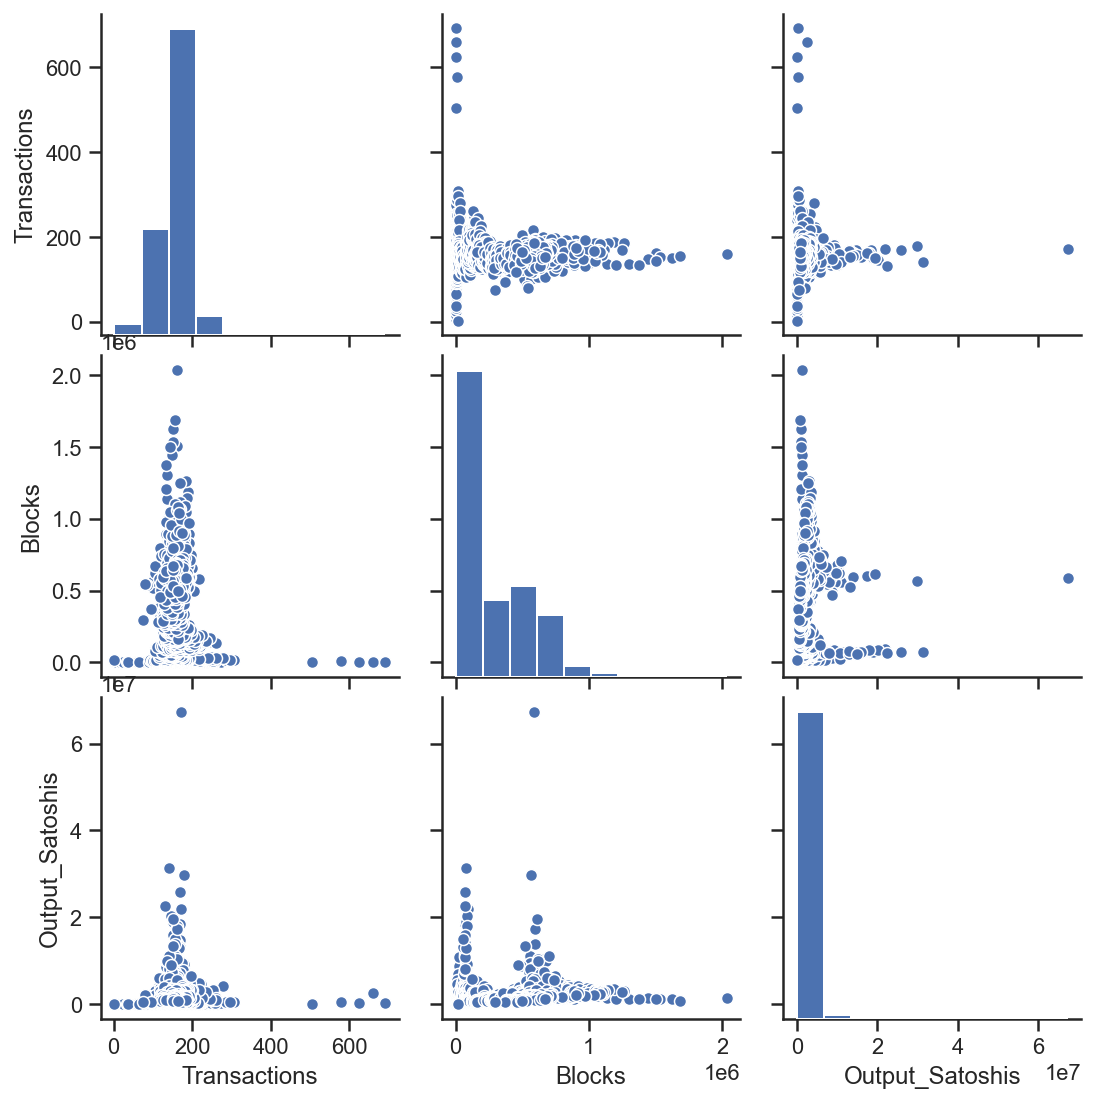

In [17]:
# check the relation among the features of data
sns.set(style="ticks")
sns.pairplot(result)

In [18]:
# select the three most important features (Transactions, Blocks, Output Satoshis) from the data
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).to_numpy()
print(data)

[[-0.61916492 -0.93730866 -3.66189407]
 [-0.61809349 -0.93714074 -2.42417364]
 [-0.617364   -0.93702641 -1.58147036]
 ...
 [-0.29173402  0.96100967 -0.08040515]
 [-0.29118499  0.83351596  0.26194305]
 [-0.37942782  0.12385633 -2.08182543]]


## Example 1: DeepLog

In [19]:
transformer_DL = DeepLogSKI()
transformer_DL.fit(data)

Epoch 1/10
100/100 [==============================] - 16s 11ms/step - loss: 1.0956 - val_loss: 0.3173
Epoch 2/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4987 - val_loss: 0.2470
Epoch 3/10
100/100 [==============================] - 0s 2ms/step - loss: 0.3694 - val_loss: 0.1844
Epoch 4/10
100/100 [==============================] - 0s 2ms/step - loss: 0.3769 - val_loss: 0.1988
Epoch 5/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5605 - val_loss: 0.1917
Epoch 6/10
100/100 [==============================] - 0s 2ms/step - loss: 0.5632 - val_loss: 0.1911
Epoch 7/10
100/100 [==============================] - 0s 2ms/step - loss: 0.3737 - val_loss: 0.2046
Epoch 8/10
100/100 [==============================] - 0s 2ms/step - loss: 0.3943 - val_loss: 0.1861
Epoch 9/10
100/100 [==============================] - 0s 2ms/step - loss: 0.3922 - val_loss: 0.1878
Epoch 10/10
100/100 [==============================] - 0s 2ms/step - loss: 0.4021 - val_loss: 0.20

In [20]:
prediction_labels_DL = transformer_DL.predict(data)

In [21]:
prediction_score_DL = transformer_DL.predict_score(data)

In [22]:
print("Prediction Labels\n", prediction_labels_DL)
print("Prediction Score\n", prediction_score_DL)

Prediction Labels
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]
Prediction Score
 [[0.        ]
 [0.26495463]
 [0.22239052]
 ...
 [0.55641556]
 [0.48936596]
 [2.28045378]]


In [23]:
# create a new column for storing the results of DeepLog method
result['anomaly_DeepLog'] = pd.Series(prediction_labels_DL.flatten())
result['anomaly_DeepLog'] = result['anomaly_DeepLog'].apply(lambda x: x == 1)
result['anomaly_DeepLog'] = result['anomaly_DeepLog'].astype(int)
result['anomaly_DeepLog'].value_counts()

0    3178
1     354
Name: anomaly_DeepLog, dtype: int64

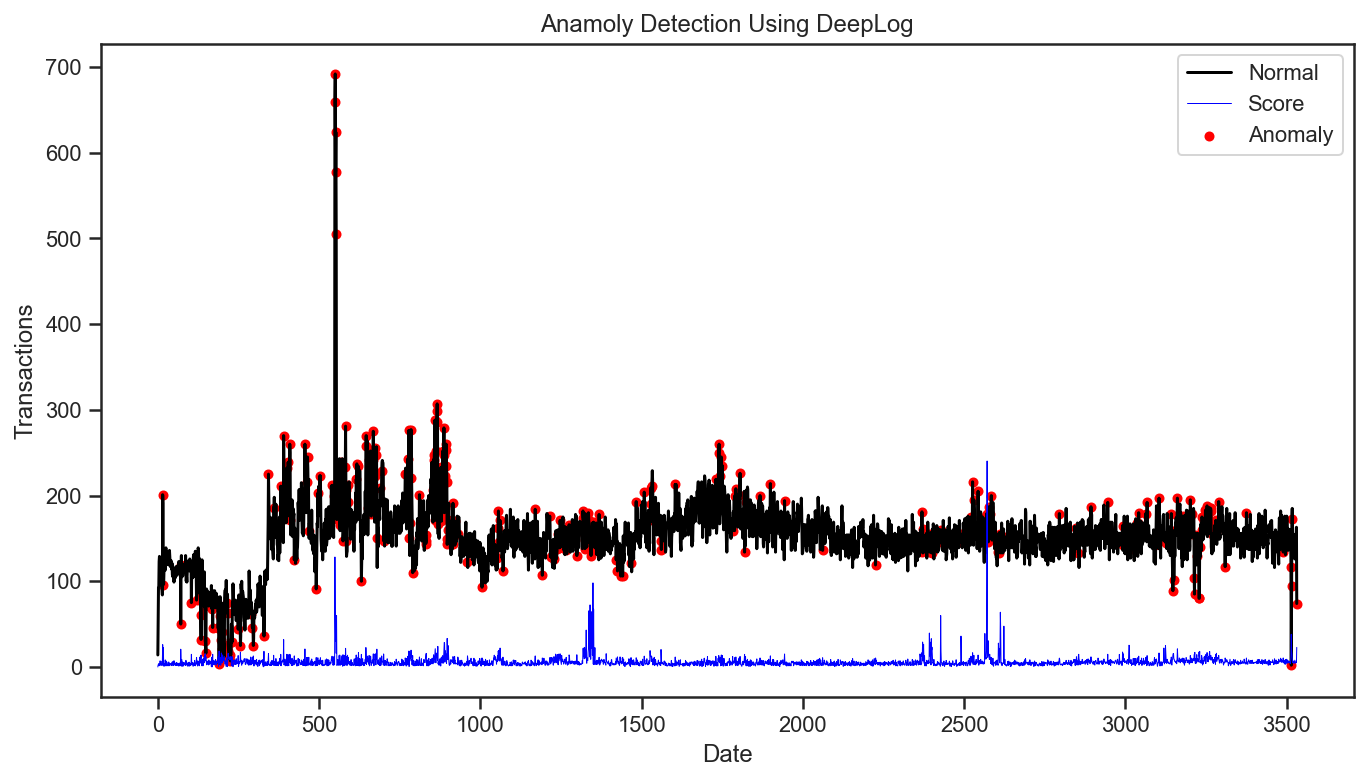

In [24]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_DeepLog'] == 1]
outlier_index=list(a.index)
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_DL.flatten()*10), color='blue', label = 'Score', linewidth=0.5)


plt.legend()
plt.title("Anamoly Detection Using DeepLog")
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.show();

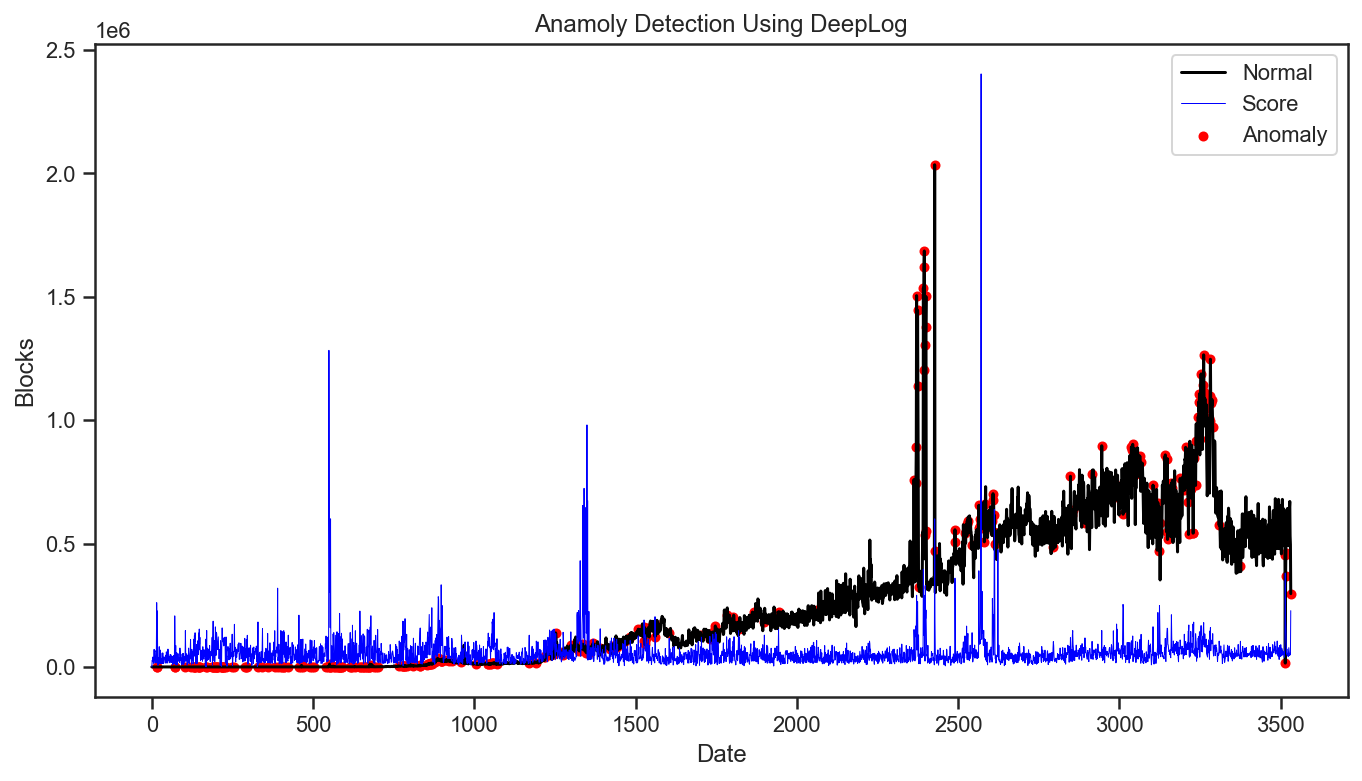

In [25]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_DeepLog'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_DL.flatten()*1e5), color='blue', label = 'Score', linewidth=0.5)


plt.legend()
plt.title("Anamoly Detection Using DeepLog")
plt.xlabel('Date')
plt.ylabel('Blocks')
plt.show();

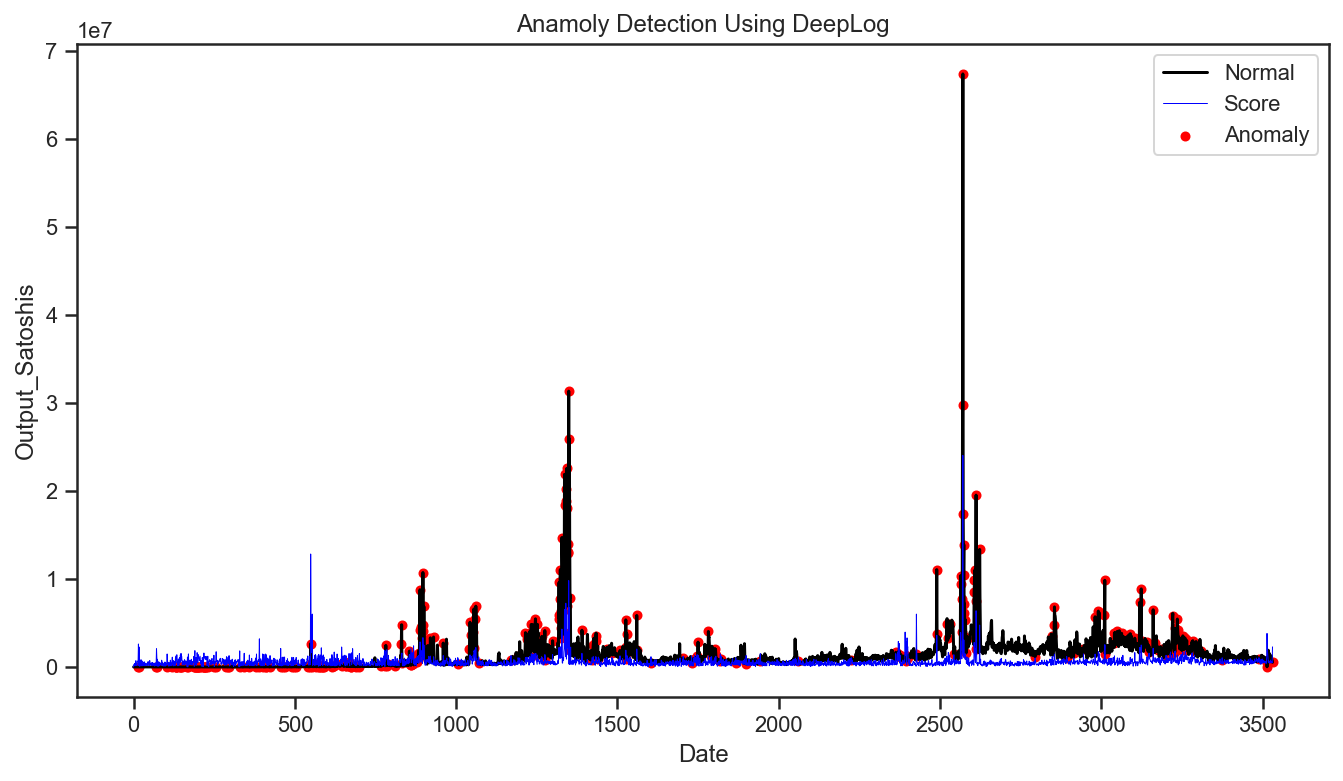

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_DeepLog'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_DL.flatten()*1e6), color='blue', label = 'Score', linewidth=0.5)


plt.legend()
plt.title("Anamoly Detection Using DeepLog")
plt.xlabel('Date')
plt.ylabel('Output_Satoshis')
plt.show();

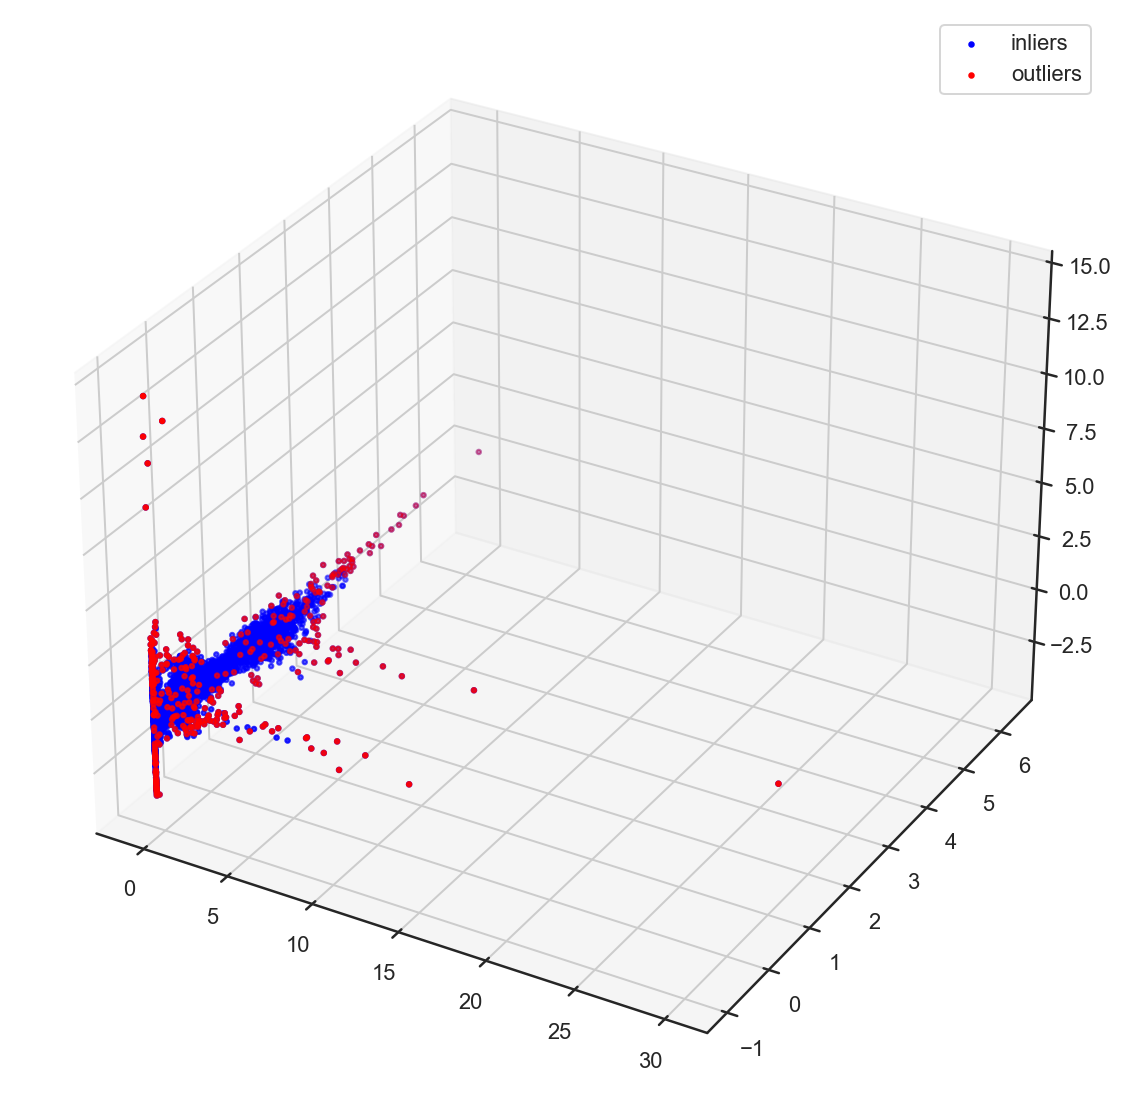

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlabel("x_composite_3")
ax.scatter(data[:, 0], data[:, 1], zs=data[:, 2], s=5, lw=1, label="inliers",c="blue")
# Plot x's for the ground truth outliers
ax.scatter(data[outlier_index,0],data[outlier_index,1], data[outlier_index,2],
           lw=1, s=5, c="red", label="outliers")
ax.legend()
plt.show()

## Example 2: Telemanom

In [28]:
#regressor using historical data by using previous data to predict furture data
transformer_TL = TelemanomSKI()
transformer_TL.fit(data)

43/43 [==============================] - 16s 148ms/step - loss: 1.3042 - val_loss: 0.9949


In [29]:
prediction_labels_TL = transformer_TL.predict(data)

In [30]:
prediction_score_TL = transformer_TL.predict_score(data)

In [31]:
print("Prediction Labels\n", prediction_labels_TL)
print("Prediction Score\n", prediction_score_TL)

Prediction Labels
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
Prediction Score
 [[25.52807608]
 [25.40674529]
 [25.26002474]
 ...
 [18.68037199]
 [18.66470849]
 [18.646084  ]]


In [32]:
# create a new column for storing the results of Telemanom method
result['anomaly_Telemanom'] = pd.Series(prediction_labels_TL.flatten()) #somehow make into 1d
result['anomaly_Telemanom'] = result['anomaly_Telemanom'].apply(lambda x: x == 1)
result['anomaly_Telemanom'] = result['anomaly_Telemanom'].astype(int)
result['anomaly_Telemanom'].value_counts()

0    3189
1     343
Name: anomaly_Telemanom, dtype: int64

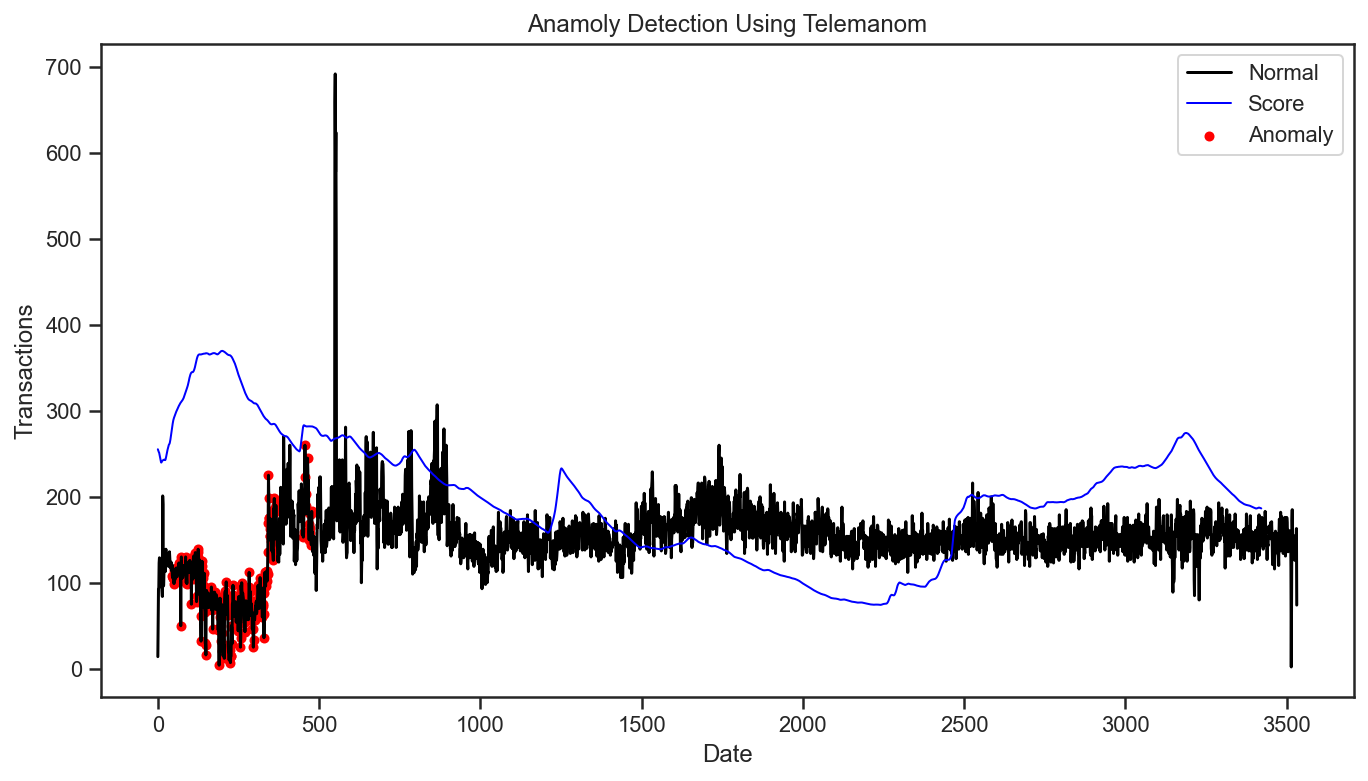

In [33]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_Telemanom'] == 1]
outlier_index=list(a.index)
ax.plot(result['Transactions'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_TL.flatten()*10), color='blue', label = 'Score', linewidth=1)
plt.legend()
plt.title("Anamoly Detection Using Telemanom")
plt.xlabel('Date')
plt.ylabel('Transactions')
plt.show();

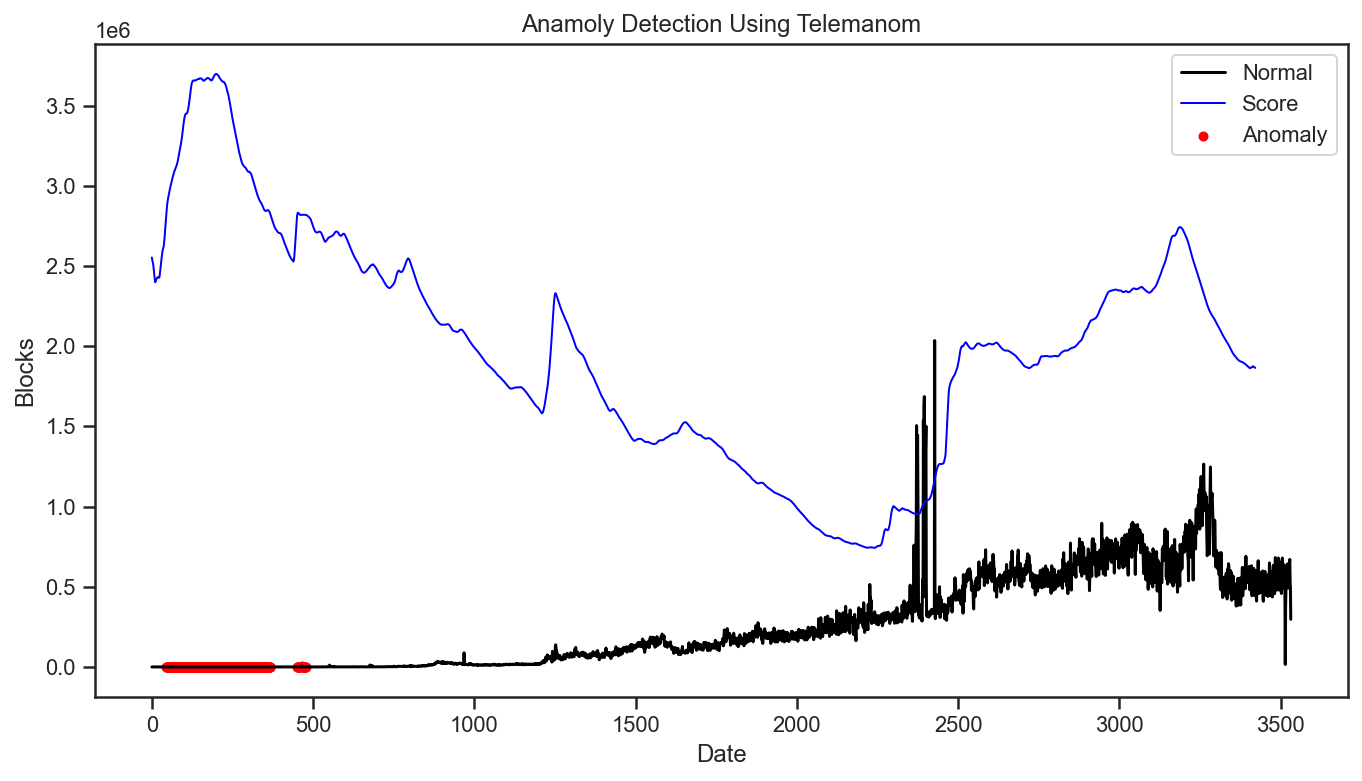

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_Telemanom'] == 1]
ax.plot(result['Blocks'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_TL.flatten()*1e5), color='blue', label = 'Score', linewidth=1)
plt.legend()
plt.title("Anamoly Detection Using Telemanom")
plt.xlabel('Date')
plt.ylabel('Blocks')
plt.show();

In [35]:
print(pd.Series(prediction_score_TL.flatten()))

0       25.528076
1       25.406745
2       25.260025
3       25.198927
4       25.134838
          ...    
3417    18.710588
3418    18.694653
3419    18.680372
3420    18.664708
3421    18.646084
Length: 3422, dtype: float64


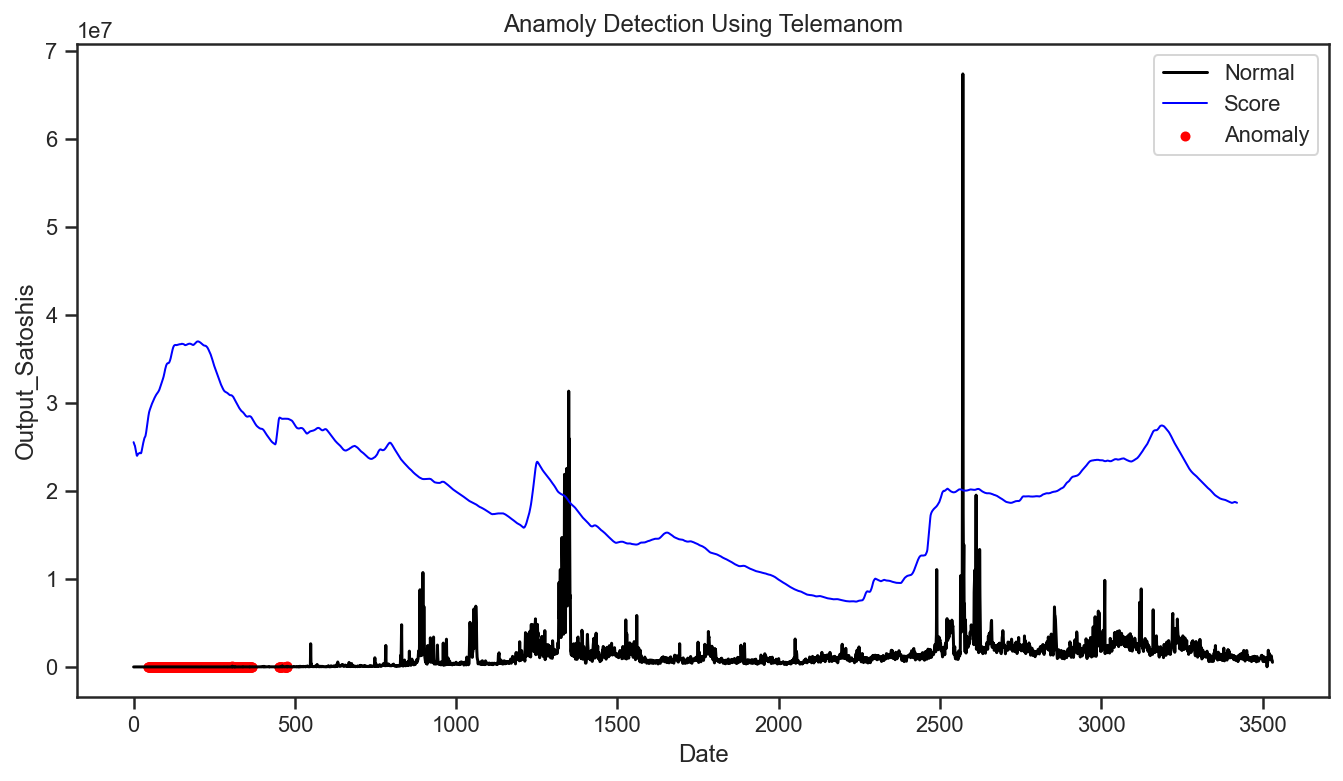

In [36]:
fig, ax = plt.subplots(figsize=(10,6))

#anomaly
a = result.loc[result['anomaly_Telemanom'] == 1]
ax.plot(result['Output_Satoshis'], color='black', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
ax.plot(pd.Series(prediction_score_TL.flatten()*1e6), color='blue', label = 'Score', linewidth=1)
plt.legend()
plt.title("Anamoly Detection Using Telemanom")
plt.xlabel('Date')
plt.ylabel('Output_Satoshis')
plt.show();

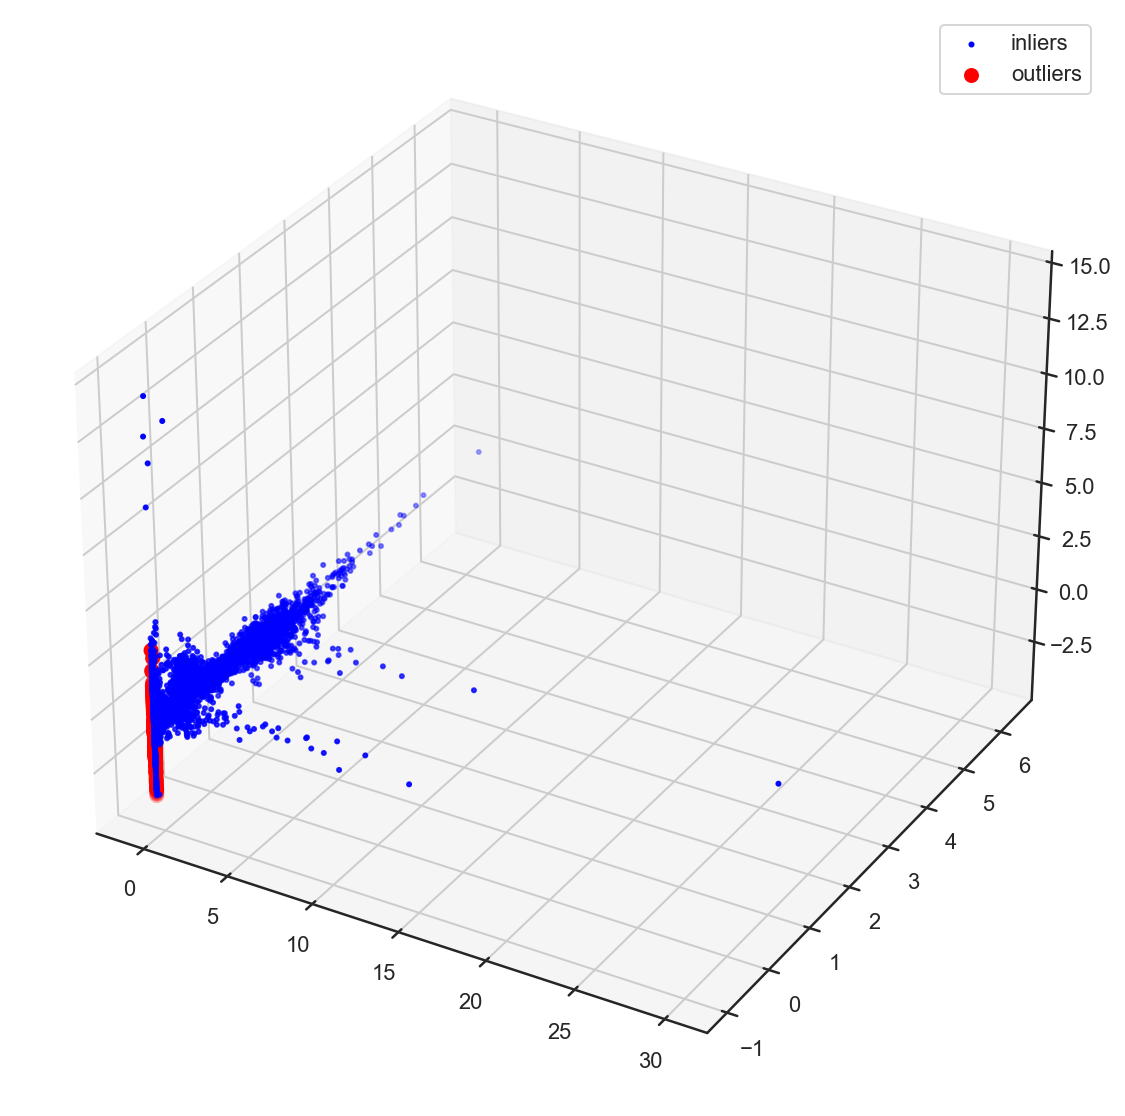

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlabel("x_composite_3")
ax.scatter(data[:, 0], data[:, 1], zs=data[:, 2], s=4, lw=1, label="inliers",c="blue")
# Plot x's for the ground truth outliers
ax.scatter(data[outlier_index,0],data[outlier_index,1], data[outlier_index,2],
           lw=2, s=30, c="red", label="outliers")
ax.legend()
plt.show()

## Searcher Example

In [38]:
from d3m import index
from d3m.metadata.base import ArgumentType
from d3m.metadata.pipeline import Pipeline, PrimitiveStep
from axolotl.backend.simple import SimpleRunner
from tods import generate_dataset, generate_problem
from tods.searcher import BruteForceSearch
from tods import generate_dataset, load_pipeline, evaluate_pipeline

In [39]:
table_path = 'nodateblock.csv'
target_index = 3 # what column is the target
time_limit = 30 # How many seconds you wanna search

In [40]:
metric = 'F1_MACRO' # F1 on both label 0 and 1

In [41]:
# Read data and generate dataset and problem
df = pd.read_csv(table_path)
dataset = generate_dataset(df, target_index=target_index)
problem_description = generate_problem(dataset, metric)

In [42]:
# Start backend
backend = SimpleRunner(random_seed=0)

In [43]:
# Start search algorithm
search = BruteForceSearch(problem_description=problem_description,
                          backend=backend)

While loading primitive 'tods.data_processing.dataset_to_dataframe', an error has been detected: (grpcio 1.36.1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('grpcio~=1.34.0'), {'tensorflow'})
Attempting to load primitive 'tods.data_processing.dataset_to_dataframe' without checking requirements.
While loading primitive 'tods.data_processing.column_parser', an error has been detected: (grpcio 1.36.1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('grpcio~=1.34.0'), {'tensorflow'})
Attempting to load primitive 'tods.data_processing.column_parser' without checking requirements.
While loading primitive 'tods.data_processing.extract_columns_by_semantic_types', an error has been detected: (grpcio 1.36.1 (/Users/wangyanghe/anaconda3/envs/tods2/lib/python3.6/site-packages), Requirement.parse('grpcio~=1.34.0'), {'tensorflow'})
Attempting to load primitive 'tods.data_processing.extract_columns_by_semantic_types' wi

In [44]:
# Find the best pipeline
best_runtime, best_pipeline_result = search.search_fit(input_data=[dataset], time_limit=time_limit)
# print(best_runtime)
best_pipeline = best_runtime.pipeline
best_output = best_pipeline_result.output

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 8

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_5 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_6 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 7         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1)                 0         
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_10 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_11 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_12 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_15 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_16 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_17 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_20 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_21 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_22 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_27 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable
Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_25 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_26 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 4)                

Traceback (most recent call last):
  File "/Users/wangyanghe/Desktop/Research/tods/tods/searcher/brute_force_search.py", line 62, in _search
    for error in pipeline_result.error:
TypeError: 'NoneType' object is not iterable


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_30 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_37 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_31 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_32 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 4)                

In [45]:
# Evaluate the best pipeline
best_scores = search.evaluate(best_pipeline).scores

Not all provided hyper-parameters for the data preparation pipeline 79ce71bd-db96-494b-a455-14f2e2ac5040 were used: ['method', 'number_of_folds', 'randomSeed', 'shuffle', 'stratified']


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_35 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_36 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 7         
_________________________________________________________________
dropout_37 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_45 (Dense)             (None, 4)                

In [46]:
print('Search History:')
for pipeline_result in search.history:
    print('-' * 52)
    print('Pipeline id:', pipeline_result.pipeline.id)
    print(pipeline_result.scores)
    
#leader board of pipelines with performance scores, the pipeline id could be used to access all these pipelines for different uses, for example higher recall

Search History:
----------------------------------------------------
Pipeline id: eb0ae5a5-b8a5-44cb-9162-f8460ef909c4
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.571701    0.571701           0     0
----------------------------------------------------
Pipeline id: 50571e7f-5d1a-4c3b-a216-ee041ad9f4c9
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.534343    0.534343           0     0
----------------------------------------------------
Pipeline id: 99639330-803d-43c8-9bb2-666117fbf87a
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.503497    0.503497           0     0
----------------------------------------------------
Pipeline id: 043e2d74-feea-4bef-8a94-c9351d538ed3
     metric     value  normalized  randomSeed  fold
0  F1_MACRO  0.493586    0.493586           0     0
----------------------------------------------------
Pipeline id: c3371b86-2e5b-4531-9448-538483e6fec1
     metric     value  normalized  randomSeed  fold
0

In [47]:
print('Best pipeline:')
print('-' * 52)
print('Pipeline id:', best_pipeline.id)
print('Pipeline json:', best_pipeline.to_json())
print('Output:')
print(best_output)
print('Scores:')
print(best_scores)
#best pipeline outputs the id and structrue of json file, it can be re-loaded by tods and to be shared to other systems

Best pipeline:
----------------------------------------------------
Pipeline id: eb0ae5a5-b8a5-44cb-9162-f8460ef909c4
Pipeline json: {"id": "eb0ae5a5-b8a5-44cb-9162-f8460ef909c4", "schema": "https://metadata.datadrivendiscovery.org/schemas/v0/pipeline.json", "created": "2021-12-03T22:14:35.381223Z", "inputs": [{"name": "inputs"}], "outputs": [{"data": "steps.7.produce", "name": "output predictions"}], "steps": [{"type": "PRIMITIVE", "primitive": {"id": "c78138d9-9377-31dc-aee8-83d9df049c60", "version": "0.3.0", "python_path": "d3m.primitives.tods.data_processing.dataset_to_dataframe", "name": "Extract a DataFrame from a Dataset"}, "arguments": {"inputs": {"type": "CONTAINER", "data": "inputs.0"}}, "outputs": [{"id": "produce"}]}, {"type": "PRIMITIVE", "primitive": {"id": "81235c29-aeb9-3828-911a-1b25319b6998", "version": "0.6.0", "python_path": "d3m.primitives.tods.data_processing.column_parser", "name": "Parses strings into their types"}, "arguments": {"inputs": {"type": "CONTAINER", 